## Overview

Similar to Pandas, GeoPandas has a `plot()` method that can plot geospatial data using Matplotlib.

We will work with California census data for 2019 to create a choropleth map of population density. We will start with a `.shp` format`shapefile` of census tracts, and join it with tabular data to get a GeoDataframe with census tract geometry and correponding populations.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [1]:
%%capture
if 'google.colab' in str(get_ipython()):
  !apt install libspatialindex-dev
  !pip install fiona shapely pyproj rtree mapclassify
  !pip install geopandas

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd


In [3]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [4]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

We will download the the census tracts shapefile and a CSV file containing a variety of population statistics for each tract.

In [5]:
shapefile_name = 'tl_2019_06_tract'
shapefile_exts = ['.shp', '.shx', '.dbf', '.prj']
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/census/'

for ext in shapefile_exts:
  url = data_url + shapefile_name + ext
  download(url)

csv_name = 'ACSST5Y2019.S0101_data.csv'
download(data_url + csv_name)


Downloaded data/tl_2019_06_tract.shp
Downloaded data/tl_2019_06_tract.shx
Downloaded data/tl_2019_06_tract.dbf
Downloaded data/tl_2019_06_tract.prj
Downloaded data/ACSST5Y2019.S0101_data.csv


## Data Pre-Processing

Let's read the census tracts shapefile and the CSV file containing population counts.

In [6]:
#### create a spatial GeoDataFrame from the .shp file
shapefile_path = os.path.join(data_folder, shapefile_name + '.shp')
tracts = gpd.read_file(shapefile_path)
tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1..."
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1..."
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1..."
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1..."
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5..."
8053,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5..."
8054,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5..."
8055,06,001,443301,06001443301,4433.01,Census Tract 4433.01,G5020,S,1577680,0,+37.4707325,-121.9129556,"POLYGON ((-121.92094 37.47505, -121.92092 37.4..."


In [7]:
type(tracts)

geopandas.geodataframe.GeoDataFrame

We now read the file containing a variety of population statistics for each tract. We read this file as a Pandas DataFrame. The CSV file contains an extra row before the header, so we specify `skiprows=[1]` to skip reading it.

In [8]:
### create a non-spatial DataFrame from the census data
csv_path = os.path.join(data_folder, csv_name)
table = pd.read_csv(csv_path, skiprows=[1]) # skip first row after header
table

,GEO_ID,NAME,S0101_C01_001E,S0101_C01_001M,S0101_C01_002E,S0101_C01_002M,S0101_C01_003E,S0101_C01_003M,S0101_C01_004E,S0101_C01_004M,...,S0101_C06_034E,S0101_C06_034M,S0101_C06_035E,S0101_C06_035M,S0101_C06_036E,S0101_C06_036M,S0101_C06_037E,S0101_C06_037M,S0101_C06_038E,S0101_C06_038M
0,1400000US06001400100,"Census Tract 4001, Alameda County, California",3120,208,188,94,56,49,168,73,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,1400000US06001400200,"Census Tract 4002, Alameda County, California",2007,120,142,50,68,30,122,46,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
2,1400000US06001400300,"Census Tract 4003, Alameda County, California",5051,309,204,120,373,114,104,80,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
3,1400000US06001400400,"Census Tract 4004, Alameda County, California",4007,344,180,70,196,96,271,103,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
4,1400000US06001400500,"Census Tract 4005, Alameda County, California",4124,357,254,82,122,55,168,87,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,1400000US06115040800,"Census Tract 408, Yuba County, California",4652,247,173,101,292,83,275,90,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8053,1400000US06115040901,"Census Tract 409.01, Yuba County, California",2720,298,153,81,219,98,84,40,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8054,1400000US06115040902,"Census Tract 409.02, Yuba County, California",1653,334,140,71,99,48,124,100,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8055,1400000US06115041000,"Census Tract 410, Yuba County, California",7298,789,580,208,534,176,476,276,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)


In [14]:
table.dtypes

GEO_ID            object
NAME              object
S0101_C01_001E     int64
S0101_C01_001M     int64
S0101_C01_002E     int64
                   ...  
S0101_C06_036M    object
S0101_C06_037E    object
S0101_C06_037M    object
S0101_C06_038E    object
S0101_C06_038M    object
Length: 458, dtype: object

To join this DataFrame with the GeoDataFrame, we need a column with unique identifiers. We use the `GEOID` column and process the id so they match exactly in both datasets.

In [16]:
filtered = table[['GEO_ID','NAME', 'S0101_C01_001E']]
filtered = filtered.rename(columns = {'S0101_C01_001E': 'Population', 'GEO_ID': 'GEOID'})

filtered['GEOID'] = filtered.GEOID.str[-11:] # index slicing of GEO_ID values to only include the 11 digits after 'US'

Finally, we do a table join using the `merge` method.

In [17]:
# merge the spatial tracts GeoDataFrame with the filtered census DataFrame on common column name
gdf = tracts.merge(filtered, on='GEOID')
gdf

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,Population
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...","Census Tract 1393.01, Los Angeles County, Cali...",4445
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...","Census Tract 1393.02, Los Angeles County, Cali...",5000
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1...","Census Tract 1395.02, Los Angeles County, Cali...",2917
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1...","Census Tract 1396, Los Angeles County, California",5060
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1...","Census Tract 1397.01, Los Angeles County, Cali...",5320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5...","Census Tract 4430.01, Alameda County, California",2891
8053,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5...","Census Tract 4430.02, Alameda County, California",6930
8054,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5...","Census Tract 4431.02, Alameda County, California",5065
8055,06,001,443301,06001443301,4433.01,Census Tract 4433.01,G5020,S,1577680,0,+37.4707325,-121.9129556,"POLYGON ((-121.92094 37.47505, -121.92092 37.4...","Census Tract 4433.01, Alameda County, California",4355


We now have spatial and non-spatial data in one place which will allow us to create a map with powerful insights.

For creating a choropleth map, we must **normalize** the population counts. US Census Bureau [recommends](https://www.census.gov/quickfacts/fact/note/US/LND110210) calculating the population density by dividing the total population by the land area. The original shapefile contains a column `ALAND` with the land area in square kilometers. Using it, we compute a new column `density` containing the persons per square kilometer.

In [19]:
# create a new population density column
gdf['density'] = 1e6*gdf['Population']/gdf['ALAND'] # square kilometer = 1,000m x 1,000m = 1,000,000m = 1e6 in scientific notation
gdf

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,NAME_y,Population,density
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...","Census Tract 1393.01, Los Angeles County, Cali...",4445,1551.127717
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...","Census Tract 1393.02, Los Angeles County, Cali...",5000,14780.261847
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1...","Census Tract 1395.02, Los Angeles County, Cali...",2917,2784.597937
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1...","Census Tract 1396, Los Angeles County, California",5060,2042.396272
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1...","Census Tract 1397.01, Los Angeles County, Cali...",5320,1566.366231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,06,001,443001,06001443001,4430.01,Census Tract 4430.01,G5020,S,768730,0,+37.5184218,-121.9515237,"POLYGON ((-121.95760 37.52392, -121.95745 37.5...","Census Tract 4430.01, Alameda County, California",2891,3760.748247
8053,06,001,443002,06001443002,4430.02,Census Tract 4430.02,G5020,S,1580323,0,+37.5168344,-121.9605916,"POLYGON ((-121.96900 37.52248, -121.96885 37.5...","Census Tract 4430.02, Alameda County, California",6930,4385.179485
8054,06,001,443102,06001443102,4431.02,Census Tract 4431.02,G5020,S,2367415,0,+37.5072245,-121.9271486,"POLYGON ((-121.93952 37.51476, -121.93926 37.5...","Census Tract 4431.02, Alameda County, California",5065,2139.464352
8055,06,001,443301,06001443301,4433.01,Census Tract 4433.01,G5020,S,1577680,0,+37.4707325,-121.9129556,"POLYGON ((-121.92094 37.47505, -121.92092 37.4...","Census Tract 4433.01, Alameda County, California",4355,2760.382334


## Create a Choropleth Map

The `plot()` method will render the data to a plot.

Reference: [geopandas.GeoDataFrame.plot](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html)

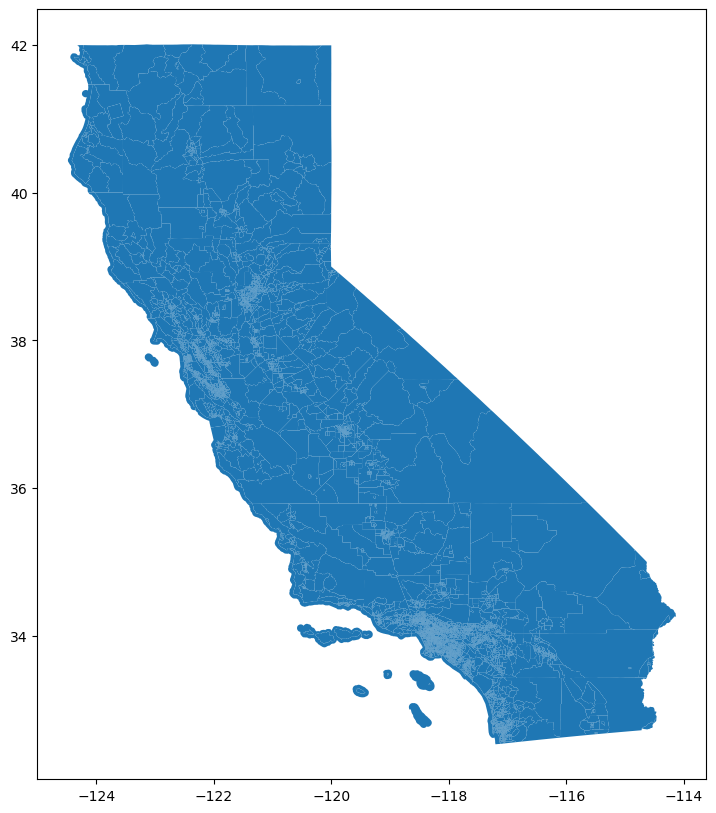

In [21]:
# plot a map of the Californian tracts
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax)
plt.show()

You can supply additional style options to change the appearance of the map. `facecolor` and `edgecolor` parameters are used to determine the fill and outline colors respectively. The stroke width can be adjusted using the `linewidth` parameter.

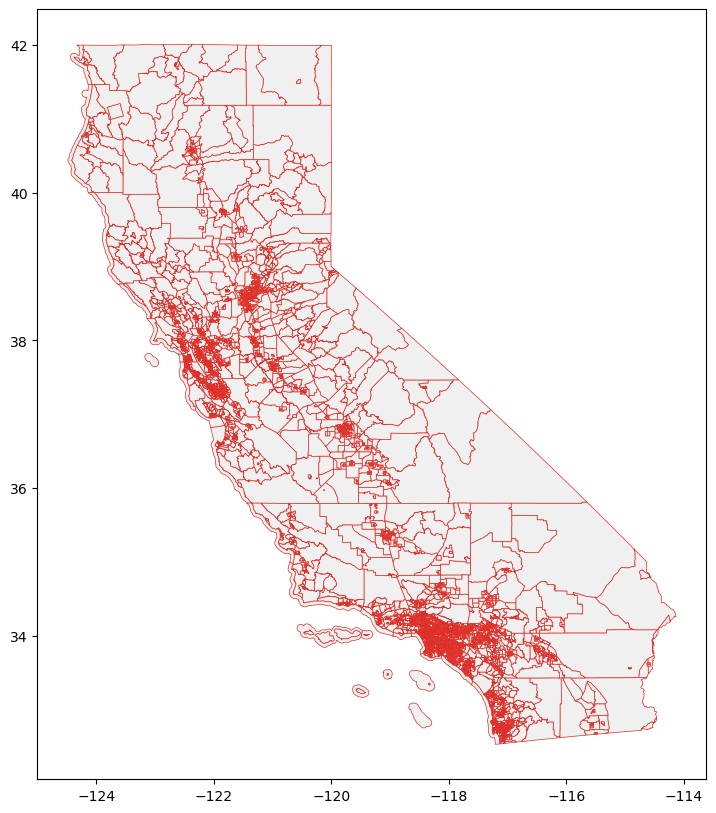

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, facecolor='#f0f0f0', edgecolor='#de2d26', linewidth=0.5)

plt.show()

We have the population density for each tract in the `density` column. We can assign a color to each polygon based on the value in this column - resulting in a choropleth map. Additionally, we need to specify a color ramp using `cmap` and classification scheme using `scheme`. The classification schedule will determine how the continuous data will be classified into discrete bins.

> Tip: You can add `_r` to any color ramp name to get a **r**eversed version of that ramp.

References:
- [Matplotlib Colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- [Mapclassify Classification Schemes](https://pysal.org/mapclassify/generated/mapclassify.classify.html#mapclassify.classify)

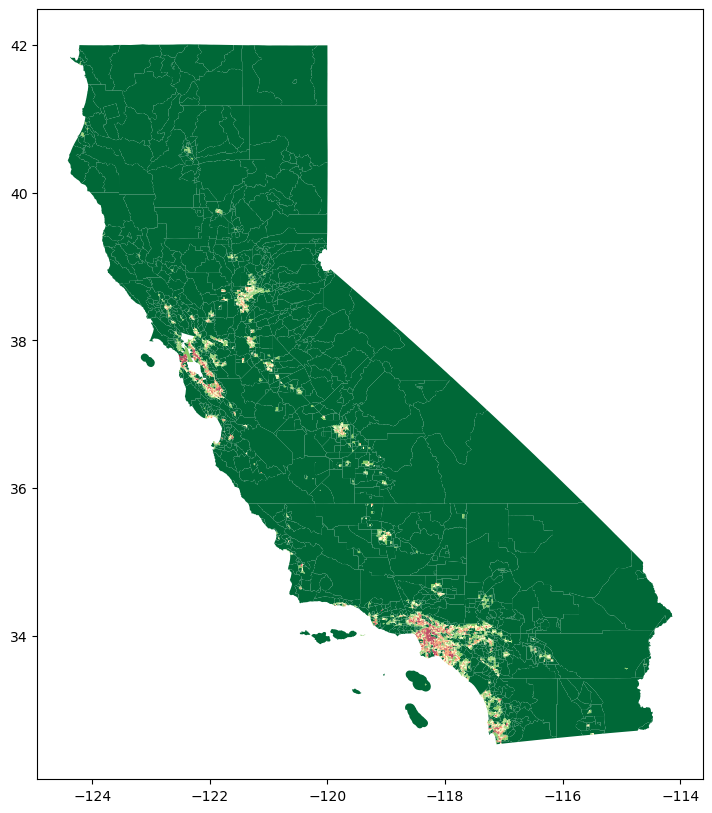

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='quantiles') # note the_r suffix to the cmap reversed the color ramp
plt.show()

Instead of the class breaks being determined by the classification scheme, we can also manually specify the ranges. This is preferable so we can have a human-interpretable legend. The `legend=True` parameter adds a legend to our plot.

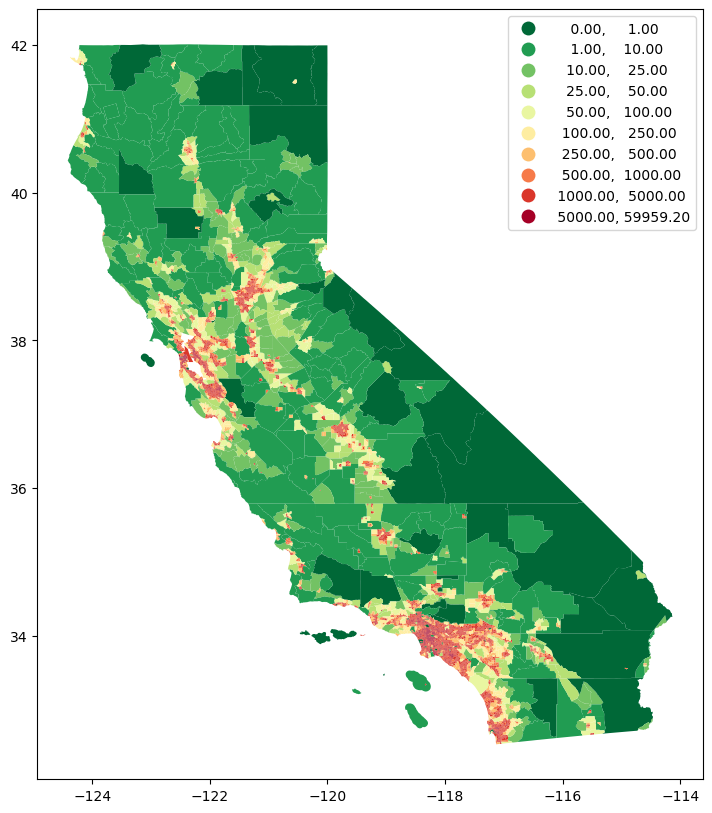

In [24]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=dict(bins=[1,10,25,50,100, 250, 500, 1000, 5000]), # user defined classification scheme arguments
         legend=True)

plt.show()

We give final touches to our map and save the result as a PNG file. Remember to call `plt.savefig()` before showing the plot as the plot gets emptied after being shown.

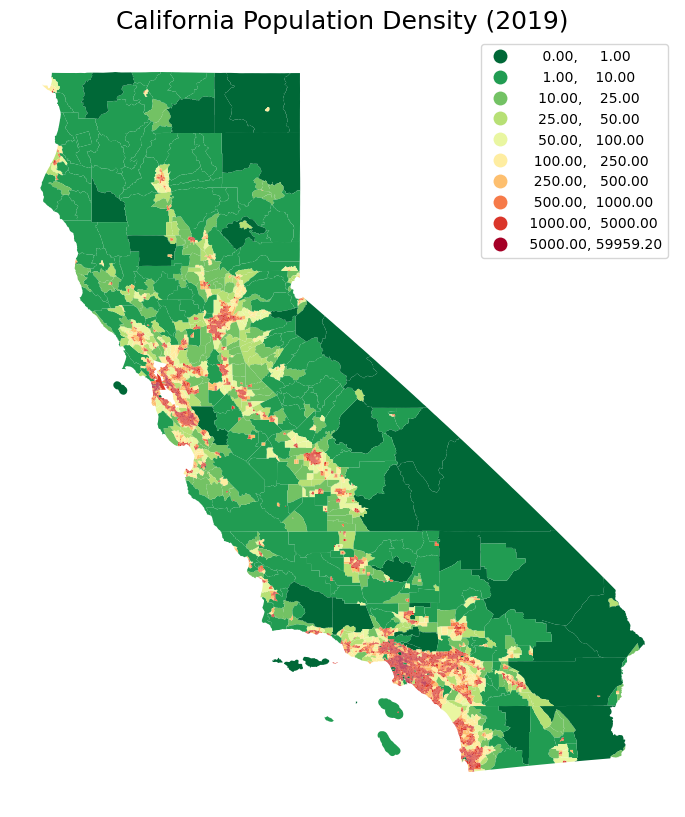

In [25]:
output_path = os.path.join(output_folder, 'california_pop.png')

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
gdf.plot(ax=ax, column='density', cmap='RdYlGn_r', scheme='User_Defined',
         classification_kwds=dict(bins=[1,10,25,50,100, 250, 500, 1000, 5000]),
         legend=True)
ax.set_axis_off()
ax.set_title('California Population Density (2019)', size = 18)

plt.savefig(output_path, dpi=300)

plt.show()

## Exercise

Plot the census tracts geodataframe `tracts` with just outlines and no fill color.

> Hint: Set the `facecolor` option to `'none'` for no fills. Check the [*style_kwds* parameter](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) of the `plot()` method for more details.

## My Solution

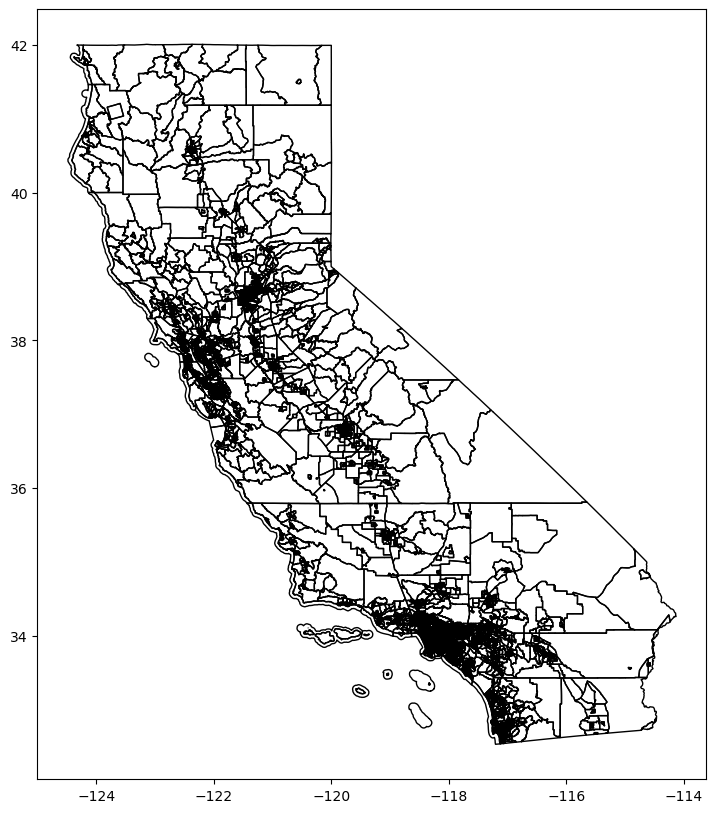

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10)
tracts.plot(ax=ax, facecolor='none')
plt.show()